In [1]:
import kagglehub
import shutil
import os
import xml.etree.ElementTree as ET
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import yaml
import pandas as pd
import seaborn as sns

In [2]:
path = kagglehub.dataset_download(handle="andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-mask-detection' dataset.
Path to dataset files: /kaggle/input/face-mask-detection


In [3]:
src = path
dst = "/content/face-mask-detection"

shutil.copytree(src, dst, dirs_exist_ok=True)

print("Copied to:", dst)

Copied to: /content/face-mask-detection


In [4]:
xml_folder = f"{dst}/annotations"
labels_out = f"{dst}/labels"

os.makedirs(labels_out, exist_ok=True)

classes = ["with_mask", "mask_weared_incorrect", "without_mask"]

def voc_to_yolo(size, box):
    w, h = size
    xmin, ymin, xmax, ymax = box

    x_center = ((xmin + xmax) / 2) / w
    y_center = ((ymin + ymax) / 2) / h
    width = (xmax - xmin) / w
    height = (ymax - ymin) / h

    return x_center, y_center, width, height

for file in os.listdir(xml_folder):
    if not file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_folder, file)
    root = ET.parse(xml_path).getroot()

    img_w = int(root.find("size/width").text)
    img_h = int(root.find("size/height").text)

    yolo_label_path = os.path.join(labels_out, file.replace(".xml", ".txt"))
    with open(yolo_label_path, "w") as out:

        for obj in root.findall("object"):
            cls = obj.find("name").text
            cls_id = classes.index(cls)

            b = obj.find("bndbox")
            xmin = int(b.find("xmin").text)
            ymin = int(b.find("ymin").text)
            xmax = int(b.find("xmax").text)
            ymax = int(b.find("ymax").text)

            bb = voc_to_yolo((img_w, img_h), (xmin, ymin, xmax, ymax))
            out.write(f"{cls_id} " + " ".join(str(v) for v in bb) + "\n")

print("XML → YOLO conversion complete.")

XML → YOLO conversion complete.


In [5]:
images_dir = f"{dst}/images"       # folder containing all images
labels_dir = f"{dst}/labels"       # folder containing all YOLO txt files

output_base = "/content/face-mask-data/"

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1


for split in ["train", "val", "test"]:
    os.makedirs(f"{output_base}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_base}/labels/{split}", exist_ok=True)


image_files = [f for f in os.listdir(images_dir)
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]

random.shuffle(image_files)
total = len(image_files)

train_end = int(total * train_ratio)
val_end   = train_end + int(total * val_ratio)

splits = {
    "train": image_files[:train_end],
    "val":   image_files[train_end:val_end],
    "test":  image_files[val_end:]
}

for split, imgs in splits.items():

    for img_name in imgs:
        img_src = os.path.join(images_dir, img_name)
        img_dst = os.path.join(output_base, "images", split, img_name)

        shutil.copy(img_src, img_dst)

        label_name = img_name.rsplit(".", 1)[0] + ".txt"
        label_src = os.path.join(labels_dir, label_name)
        label_dst = os.path.join(output_base, "labels", split, label_name)

        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)

print("✅ Dataset split completed!")


✅ Dataset split completed!


In [6]:
yaml_content = f"""
path: /content/face-mask-data
train: /content/face-mask-data/images/train
val: /content/face-mask-data/images/val
test: /content/face-mask-data/images/test
names: {classes}
"""

with open("/content/face-mask-data/dataset.yaml", "w") as f:
    f.write(yaml_content)

print("🟢 dataset.yaml created!")

🟢 dataset.yaml created!


In [7]:
old_data_path = '/content/face-mask-detection'
if os.path.exists(old_data_path):
    shutil.rmtree(old_data_path)
    print(f"Successfully deleted: {old_data_path}")
else:
    print(f"Directory not found: {old_data_path}")

Successfully deleted: /content/face-mask-detection


In [8]:
yaml_file = '/content/face-mask-data/dataset.yaml'

In [14]:
with open(yaml_file, "r") as f:
    data = yaml.safe_load(f)

CLASS_NAMES = data["names"]
NUM_CLASSES = len(CLASS_NAMES)

train_img_dir = data["train"]
train_lbl_dir = valid_img_dir.replace("images", "labels")

train_images = [f for f in os.listdir(train_img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
print("Total train images:", len(train_images))

Total train images: 597


In [15]:
with open(yaml_file, "r") as f:
    data = yaml.safe_load(f)

CLASS_NAMES = data["names"]
NUM_CLASSES = len(CLASS_NAMES)

valid_img_dir = data["val"]
valid_lbl_dir = valid_img_dir.replace("images", "labels")

valid_images = [f for f in os.listdir(valid_img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
print("Total validation images:", len(valid_images))

Total validation images: 170


In [16]:
with open(yaml_file, "r") as f:
    data = yaml.safe_load(f)

CLASS_NAMES = data["names"]
NUM_CLASSES = len(CLASS_NAMES)

test_img_dir = data["test"]
test_lbl_dir = valid_img_dir.replace("images", "labels")

test_images = [f for f in os.listdir(test_img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
print("Total test images:", len(test_images))

Total test images: 86


In [17]:
exploration_df = pd.DataFrame({
    "Type": ["Train", "Validation", "Test"],
    "Images": [len(train_images), len(valid_images), len(test_images)]
})

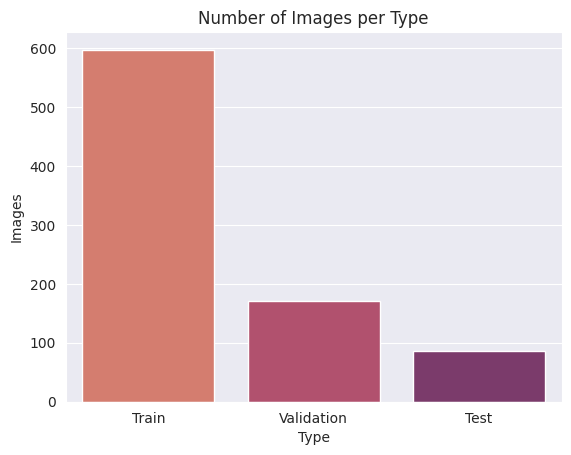

In [23]:
sns.set_style('darkgrid')
sns.barplot(data= exploration_df, x= 'Type', y= 'Images', palette= 'flare', hue= 'Type')
plt.title("Number of Images per Type")
plt.show()

In [25]:
class_counts = Counter()

for lbl_file in os.listdir(train_lbl_dir):
    if lbl_file.endswith(".txt"):
        with open(os.path.join(train_lbl_dir, lbl_file), "r") as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

In [27]:
class_counts

Counter({0: 608, 2: 140, 1: 29})

In [26]:
class_df = pd.DataFrame([
    {"class_id": cid, "class_name": CLASS_NAMES[cid], "count": cnt}
    for cid, cnt in class_counts.items()
])

print(class_df)

   class_id             class_name  count
0         0              with_mask    608
1         2           without_mask    140
2         1  mask_weared_incorrect     29


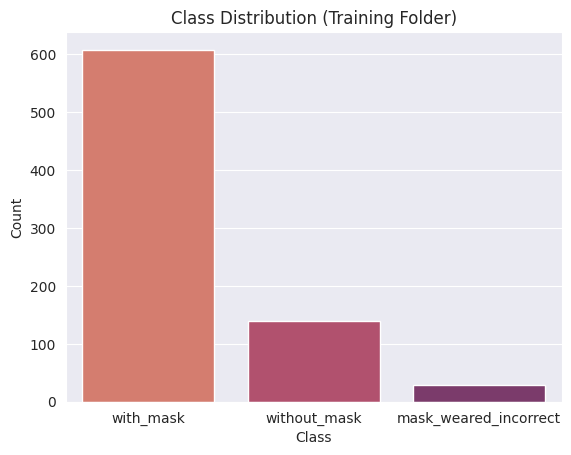

In [32]:
sns.barplot(data= class_df, x= 'class_name', y= 'count', palette= 'flare', hue= 'class_name')
plt.title("Class Distribution (Training Folder)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()